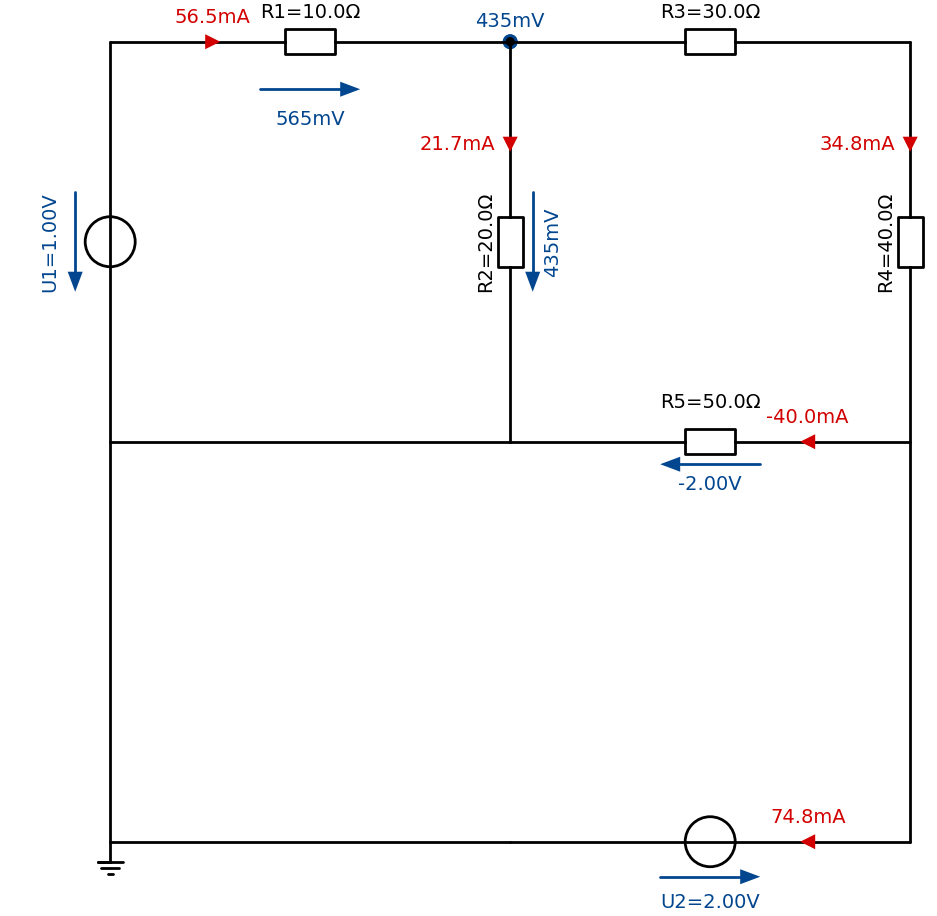

In [1]:
from CircuitCalculator.SimpleCircuit.styles.styling import select
select(style='DIN')
from CircuitCalculator.SimpleSimulation.simulator import simulate
simulate('test_simple_circuit.yaml')
# 